In [2]:
# Import required libraries
import os
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.optim import AdamW
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torchvision import models
from transformers import ViTForImageClassification, get_cosine_schedule_with_warmup
from sklearn.metrics import accuracy_score, classification_report, precision_score, recall_score, confusion_matrix
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cv2

In [3]:
# Set random seed
torch.manual_seed(42)
np.random.seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(42)

In [4]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


In [5]:
# Dataset paths
train_dir = '/content/drive/MyDrive/MRI_Dataset/Training'
test_dir = '/content/drive/MyDrive/MRI_Dataset/Testing'

In [6]:
# Data transformations (standardized to 224x224 for both models)
train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(10),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

test_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [7]:
# Load datasets
train_dataset = ImageFolder(train_dir, transform=train_transforms)
test_dataset = ImageFolder(test_dir, transform=test_transforms)

# Data loaders
batch_size = 16
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True)

# Class info
class_names = train_dataset.classes
num_classes = len(class_names)
print(f"Classes: {class_names}")
print(f"Training samples: {len(train_dataset)}")
print(f"Testing samples: {len(test_dataset)}")

# Class weights
class_counts = np.bincount([train_dataset.targets[i] for i in range(len(train_dataset))])
class_weights = 1.0 / torch.tensor(class_counts, dtype=torch.float)
class_weights = class_weights / class_weights.sum() * len(class_counts)
class_weights = class_weights.to(device)
print(f"Class weights: {class_weights}")

# Loss and optimizer settings (shared)
criterion = nn.CrossEntropyLoss(weight=class_weights)
num_epochs = 10
num_training_steps = len(train_loader) * num_epochs

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Classes: ['glioma', 'meningioma', 'notumor', 'pituitary']
Training samples: 5737
Testing samples: 1311
Class weights: tensor([1.0602, 1.0657, 0.8947, 0.9794], device='cuda:0')


In [8]:

# Hybrid Model Definition (Updated for ViT)
class HybridModel(nn.Module):
    def __init__(self, vit_path, resnet_path, num_classes):
        super(HybridModel, self).__init__()
        # Load ViT model from saved pretrained directory
        self.vit = ViTForImageClassification.from_pretrained(
            vit_path,
            num_labels=num_classes,
            ignore_mismatched_sizes=True
        )
        # Load ResNet50
        self.resnet = models.resnet50(pretrained=False)
        num_features = self.resnet.fc.in_features
        self.resnet.fc = nn.Linear(num_features, num_classes)
        self.resnet.load_state_dict(torch.load(resnet_path))
        self.vit.to(device)
        self.resnet.to(device)

    def forward(self, x):
        with torch.no_grad():
            vit_logits = self.vit(x).logits
            resnet_logits = self.resnet(x)
        # Average the logits
        hybrid_logits = (vit_logits + resnet_logits) / 2
        return hybrid_logits


In [10]:
# ============== Train ViT Model ==============
print("\n" + "="*50)
print("Training ViT Base Model")
print("="*50)

vit_model = ViTForImageClassification.from_pretrained(
    'google/vit-base-patch16-224-in21k',
    num_labels=num_classes,
    ignore_mismatched_sizes=True
)
vit_model.to(device)

vit_optimizer = AdamW(vit_model.parameters(), lr=2e-5, weight_decay=0.01)
vit_scheduler = get_cosine_schedule_with_warmup(vit_optimizer, num_warmup_steps=0, num_training_steps=num_training_steps)

# Tracking metrics for ViT
vit_train_losses, vit_test_losses = [], []
vit_train_accs, vit_test_accs = [], []
vit_train_precisions, vit_train_recalls = [], []
vit_test_precisions, vit_test_recalls = [], []

best_vit_acc = 0.0
vit_best_path = '/content/drive/MyDrive/vit_base_best.pth'
vit_save_dir = '/content/drive/MyDrive/vit-base-brain-tumor'

for epoch in range(num_epochs):
    vit_model.train()
    total_train_loss = 0.0
    train_preds, train_labels = [], []

    for batch in tqdm(train_loader, desc=f"ViT Epoch {epoch+1}/{num_epochs}"):
        images, labels = batch
        images, labels = images.to(device), labels.to(device)
        outputs = vit_model(images).logits
        loss = criterion(outputs, labels)
        vit_optimizer.zero_grad()
        loss.backward()
        vit_optimizer.step()
        vit_scheduler.step()
        total_train_loss += loss.item()
        _, preds = torch.max(outputs, dim=1)
        train_preds.extend(preds.cpu().numpy())
        train_labels.extend(labels.cpu().numpy())


Training ViT Base Model


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
ViT Epoch 10/10: 100%|██████████| 359/359 [03:09<00:00,  1.89it/s]


In [12]:
train_acc = accuracy_score(train_labels, train_preds)
train_precision = precision_score(train_labels, train_preds, average='weighted', zero_division=0)
train_recall = recall_score(train_labels, train_preds, average='weighted', zero_division=0)
avg_train_loss = total_train_loss / len(train_loader)
vit_train_losses.append(avg_train_loss)
vit_train_accs.append(train_acc)
vit_train_precisions.append(train_precision)
vit_train_recalls.append(train_recall)



In [14]:
   # Evaluation
vit_model.eval()
total_test_loss = 0.0
test_preds, test_labels = [], []
with torch.no_grad():
    for batch in tqdm(test_loader, desc="ViT Evaluating"):
        images, labels = batch
        images, labels = images.to(device), labels.to(device)
        outputs = vit_model(images).logits
        loss = criterion(outputs, labels)
        total_test_loss += loss.item()
        _, preds = torch.max(outputs, dim=1)
        test_preds.extend(preds.cpu().numpy())
        test_labels.extend(labels.cpu().numpy())

ViT Evaluating:   0%|          | 0/82 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
ViT Evaluating: 100%|██████████| 82/82 [02:30<00:00,  1.83s/it]


In [19]:
    # Test metrics
test_acc = accuracy_score(test_labels, test_preds)
test_precision = precision_score(test_labels, test_preds, average='weighted', zero_division=0)
test_recall = recall_score(test_labels, test_preds, average='weighted', zero_division=0)
avg_test_loss = total_test_loss / len(test_loader)
vit_test_losses.append(avg_test_loss)
vit_test_accs.append(test_acc)
vit_test_precisions.append(test_precision)
vit_test_recalls.append(test_recall)

print(f"ViT Epoch {epoch+1}/{num_epochs}, Train Loss: {avg_train_loss:.4f}, Train Acc: {train_acc:.4f}, "
      f"Train Precision: {train_precision:.4f}, Train Recall: {train_recall:.4f}, "
      f"Test Loss: {avg_test_loss:.4f}, Test Acc: {test_acc:.4f}, "
      f"Test Precision: {test_precision:.4f}, Test Recall: {test_recall:.4f}")

if test_acc > best_vit_acc:
  best_vit_acc = test_acc
  torch.save(vit_model.state_dict(), vit_best_path)
  vit_model.save_pretrained(vit_save_dir)

ViT Epoch 10/10, Train Loss: 0.0185, Train Acc: 0.9984, Train Precision: 0.9984, Train Recall: 0.9984, Test Loss: 0.0295, Test Acc: 0.9939, Test Precision: 0.9940, Test Recall: 0.9939


In [21]:
# ============== Train ResNet50 Model ==============
print("\n" + "="*50)
print("Training ResNet50 Model")
print("="*50)

resnet_model = models.resnet50(pretrained=True)
num_features = resnet_model.fc.in_features
resnet_model.fc = nn.Linear(num_features, num_classes)
resnet_model.to(device)

resnet_optimizer = AdamW(resnet_model.parameters(), lr=2e-5, weight_decay=0.01)
resnet_scheduler = get_cosine_schedule_with_warmup(resnet_optimizer, num_warmup_steps=0, num_training_steps=num_training_steps)

# Tracking metrics for ResNet
resnet_train_losses, resnet_test_losses = [], []
resnet_train_accs, resnet_test_accs = [], []
resnet_train_precisions, resnet_train_recalls = [], []
resnet_test_precisions, resnet_test_recalls = [], []

best_resnet_acc = 0.0
resnet_best_path = '/content/drive/MyDrive/resnet50_best.pth'

for epoch in range(num_epochs):
    resnet_model.train()
    total_train_loss = 0.0
    train_preds, train_labels = [], []

    for batch in tqdm(train_loader, desc=f"ResNet Epoch {epoch+1}/{num_epochs}"):
        images, labels = batch
        images, labels = images.to(device), labels.to(device)
        outputs = resnet_model(images)
        loss = criterion(outputs, labels)
        resnet_optimizer.zero_grad()
        loss.backward()
        resnet_optimizer.step()
        resnet_scheduler.step()
        total_train_loss += loss.item()
        _, preds = torch.max(outputs, dim=1)
        train_preds.extend(preds.cpu().numpy())
        train_labels.extend(labels.cpu().numpy())

    # Training metrics
    train_acc = accuracy_score(train_labels, train_preds)
    train_precision = precision_score(train_labels, train_preds, average='weighted', zero_division=0)
    train_recall = recall_score(train_labels, train_preds, average='weighted', zero_division=0)
    avg_train_loss = total_train_loss / len(train_loader)
    resnet_train_losses.append(avg_train_loss)
    resnet_train_accs.append(train_acc)
    resnet_train_precisions.append(train_precision)
    resnet_train_recalls.append(train_recall)

    # Evaluation
    resnet_model.eval()
    total_test_loss = 0.0
    test_preds, test_labels = [], []
    with torch.no_grad():
        for batch in tqdm(test_loader, desc="ResNet Evaluating"):
            images, labels = batch
            images, labels = images.to(device), labels.to(device)
            outputs = resnet_model(images)
            loss = criterion(outputs, labels)
            total_test_loss += loss.item()
            _, preds = torch.max(outputs, dim=1)
            test_preds.extend(preds.cpu().numpy())
            test_labels.extend(labels.cpu().numpy())

    # Test metrics
    test_acc = accuracy_score(test_labels, test_preds)
    test_precision = precision_score(test_labels, test_preds, average='weighted', zero_division=0)
    test_recall = recall_score(test_labels, test_preds, average='weighted', zero_division=0)
    avg_test_loss = total_test_loss / len(test_loader)
    resnet_test_losses.append(avg_test_loss)
    resnet_test_accs.append(test_acc)
    resnet_test_precisions.append(test_precision)
    resnet_test_recalls.append(test_recall)

    print(f"ResNet Epoch {epoch+1}/{num_epochs}, Train Loss: {avg_train_loss:.4f}, Train Acc: {train_acc:.4f}, "
          f"Train Precision: {train_precision:.4f}, Train Recall: {train_recall:.4f}, "
          f"Test Loss: {avg_test_loss:.4f}, Test Acc: {test_acc:.4f}, "
          f"Test Precision: {test_precision:.4f}, Test Recall: {test_recall:.4f}")

    if test_acc > best_resnet_acc:
        best_resnet_acc = test_acc
        torch.save(resnet_model.state_dict(), resnet_best_path)



Training ResNet50 Model


/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
ResNet Epoch 1/10:   0%|          | 0/359 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation migh

ResNet Epoch 1/10, Train Loss: 0.3942, Train Acc: 0.8667, Train Precision: 0.8661, Train Recall: 0.8667, Test Loss: 0.1687, Test Acc: 0.9405, Test Precision: 0.9454, Test Recall: 0.9405


ResNet Epoch 2/10:   0%|          | 0/359 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
ResNet Evaluating:   0%|          | 0/82 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if nec

ResNet Epoch 2/10, Train Loss: 0.1449, Train Acc: 0.9554, Train Precision: 0.9554, Train Recall: 0.9554, Test Loss: 0.0929, Test Acc: 0.9687, Test Precision: 0.9690, Test Recall: 0.9687


ResNet Epoch 3/10:   0%|          | 0/359 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
ResNet Evaluating:   0%|          | 0/82 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if nec

ResNet Epoch 3/10, Train Loss: 0.1012, Train Acc: 0.9691, Train Precision: 0.9692, Train Recall: 0.9691, Test Loss: 0.0491, Test Acc: 0.9847, Test Precision: 0.9852, Test Recall: 0.9847


ResNet Epoch 4/10:   0%|          | 0/359 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
ResNet Evaluating:   0%|          | 0/82 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if nec

ResNet Epoch 4/10, Train Loss: 0.0631, Train Acc: 0.9822, Train Precision: 0.9823, Train Recall: 0.9822, Test Loss: 0.0397, Test Acc: 0.9870, Test Precision: 0.9874, Test Recall: 0.9870


ResNet Epoch 5/10:   0%|          | 0/359 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
ResNet Evaluating:   0%|          | 0/82 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if nec

ResNet Epoch 5/10, Train Loss: 0.0454, Train Acc: 0.9862, Train Precision: 0.9862, Train Recall: 0.9862, Test Loss: 0.0223, Test Acc: 0.9939, Test Precision: 0.9940, Test Recall: 0.9939


ResNet Epoch 6/10:   0%|          | 0/359 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
ResNet Evaluating:   0%|          | 0/82 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if nec

ResNet Epoch 6/10, Train Loss: 0.0386, Train Acc: 0.9894, Train Precision: 0.9894, Train Recall: 0.9894, Test Loss: 0.0285, Test Acc: 0.9916, Test Precision: 0.9918, Test Recall: 0.9916


ResNet Epoch 7/10:   0%|          | 0/359 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
ResNet Evaluating:   0%|          | 0/82 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if nec

ResNet Epoch 7/10, Train Loss: 0.0269, Train Acc: 0.9932, Train Precision: 0.9932, Train Recall: 0.9932, Test Loss: 0.0446, Test Acc: 0.9855, Test Precision: 0.9864, Test Recall: 0.9855


ResNet Epoch 8/10:   0%|          | 0/359 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
ResNet Evaluating:   0%|          | 0/82 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if nec

ResNet Epoch 8/10, Train Loss: 0.0200, Train Acc: 0.9953, Train Precision: 0.9953, Train Recall: 0.9953, Test Loss: 0.0256, Test Acc: 0.9931, Test Precision: 0.9933, Test Recall: 0.9931


ResNet Epoch 9/10:   0%|          | 0/359 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
ResNet Evaluating:   0%|          | 0/82 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if nec

ResNet Epoch 9/10, Train Loss: 0.0218, Train Acc: 0.9937, Train Precision: 0.9937, Train Recall: 0.9937, Test Loss: 0.0215, Test Acc: 0.9931, Test Precision: 0.9932, Test Recall: 0.9931


ResNet Epoch 10/10:   0%|          | 0/359 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
ResNet Evaluating:   0%|          | 0/82 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if ne

ResNet Epoch 10/10, Train Loss: 0.0182, Train Acc: 0.9956, Train Precision: 0.9956, Train Recall: 0.9956, Test Loss: 0.0188, Test Acc: 0.9954, Test Precision: 0.9955, Test Recall: 0.9954


In [22]:
# ============== Hybrid Model Evaluation ==============
print("\n" + "="*50)
print("Evaluating Hybrid Model")
print("="*50)

# Create hybrid model using best saved models
hybrid_model = HybridModel(vit_save_dir, resnet_best_path, num_classes)
hybrid_model.eval()

# Final evaluation with hybrid
test_preds, test_labels = [], []
with torch.no_grad():
    for batch in tqdm(test_loader, desc="Hybrid Final Evaluation"):
        images, labels = batch
        images, labels = images.to(device), labels.to(device)
        outputs = hybrid_model(images)
        _, preds = torch.max(outputs, dim=1)
        test_preds.extend(preds.cpu().numpy())
        test_labels.extend(labels.cpu().numpy())

# Hybrid metrics
hybrid_acc = accuracy_score(test_labels, test_preds)
hybrid_precision = precision_score(test_labels, test_preds, average='weighted', zero_division=0)
hybrid_recall = recall_score(test_labels, test_preds, average='weighted', zero_division=0)

print(f"\nHybrid Final Test Accuracy: {hybrid_acc:.4f}")
print(f"Hybrid Final Test Precision: {hybrid_precision:.4f}")
print(f"Hybrid Final Test Recall: {hybrid_recall:.4f}")
print("\nHybrid Classification Report:")
print(classification_report(test_labels, test_preds, target_names=class_names))



Evaluating Hybrid Model


/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
Hybrid Final Evaluation:   0%|          | 0/82 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if n


Hybrid Final Test Accuracy: 0.9962
Hybrid Final Test Precision: 0.9962
Hybrid Final Test Recall: 0.9962

Hybrid Classification Report:
              precision    recall  f1-score   support

      glioma       1.00      0.99      0.99       300
  meningioma       0.98      1.00      0.99       306
     notumor       1.00      1.00      1.00       405
   pituitary       1.00      0.99      1.00       300

    accuracy                           1.00      1311
   macro avg       1.00      1.00      1.00      1311
weighted avg       1.00      1.00      1.00      1311



In [23]:
# Compare with individual best
vit_final_acc = max(vit_test_accs)
resnet_final_acc = max(resnet_test_accs)
print(f"\nComparison:")
print(f"ViT Best Test Acc: {vit_final_acc:.4f}")
print(f"ResNet Best Test Acc: {resnet_final_acc:.4f}")
print(f"Hybrid Test Acc: {hybrid_acc:.4f}")


Comparison:
ViT Best Test Acc: 0.9939
ResNet Best Test Acc: 0.9954
Hybrid Test Acc: 0.9962


In [24]:
# Class distribution
class_counts_dict = dict(zip(class_names, class_counts))
print(f"\nClass Distribution: {class_counts_dict}")


Class Distribution: {'glioma': np.int64(1346), 'meningioma': np.int64(1339), 'notumor': np.int64(1595), 'pituitary': np.int64(1457)}


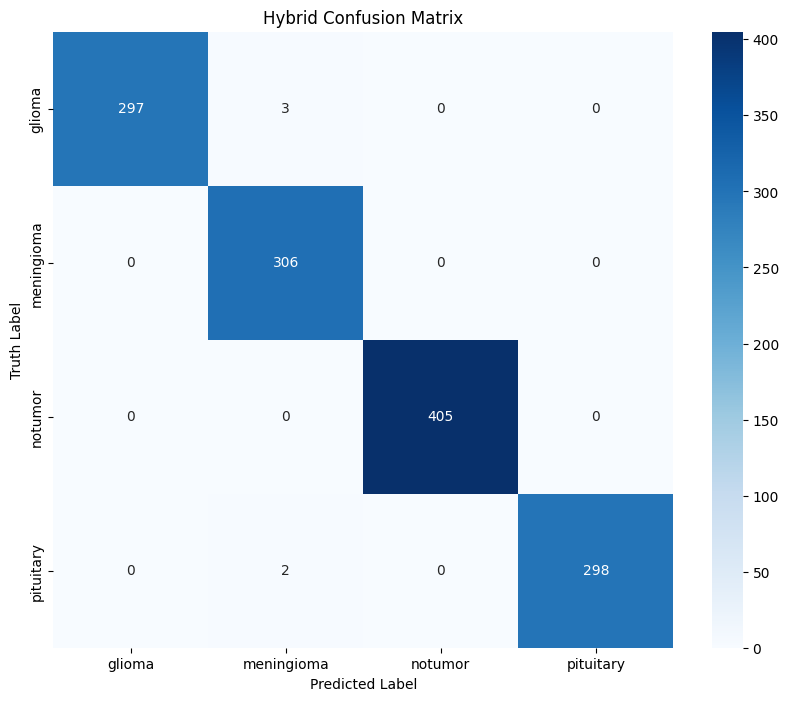

In [26]:
# Hybrid Confusion matrix
cm = confusion_matrix(test_labels, test_preds)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('Truth Label')
plt.title('Hybrid Confusion Matrix')
plt.savefig('/content/drive/My/hybrid_confusion_matrix.png')
plt.show()

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


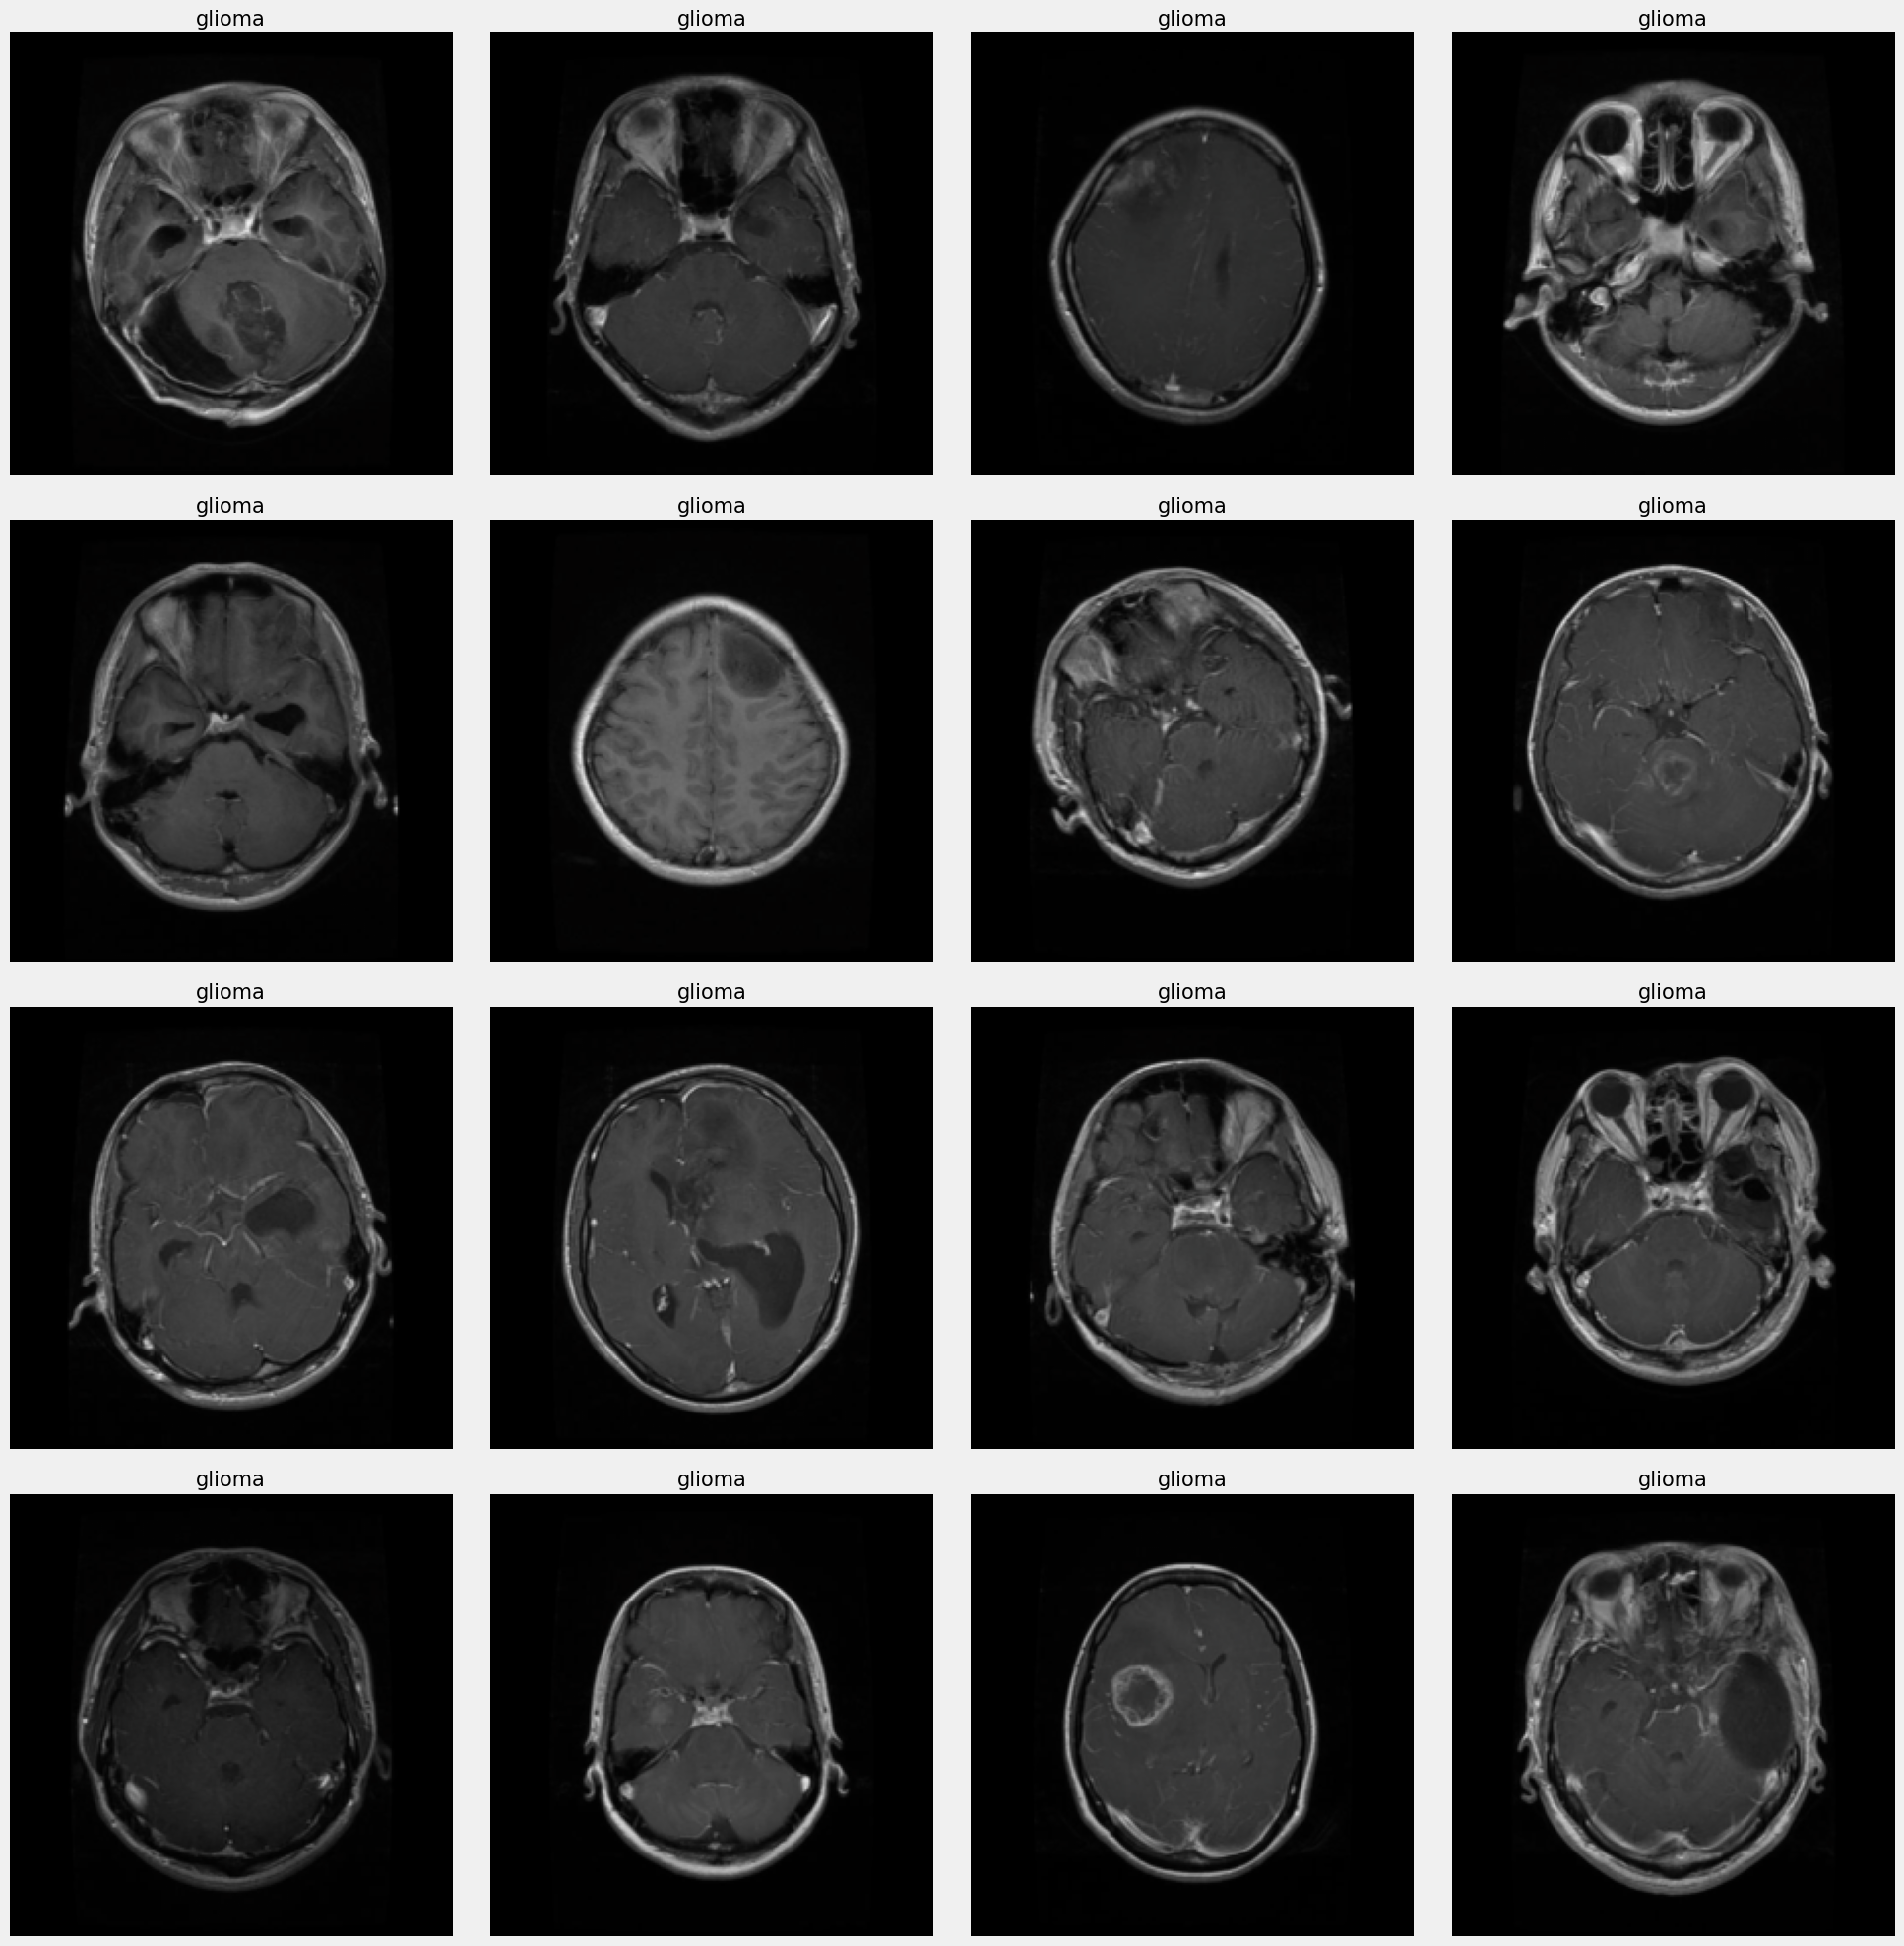

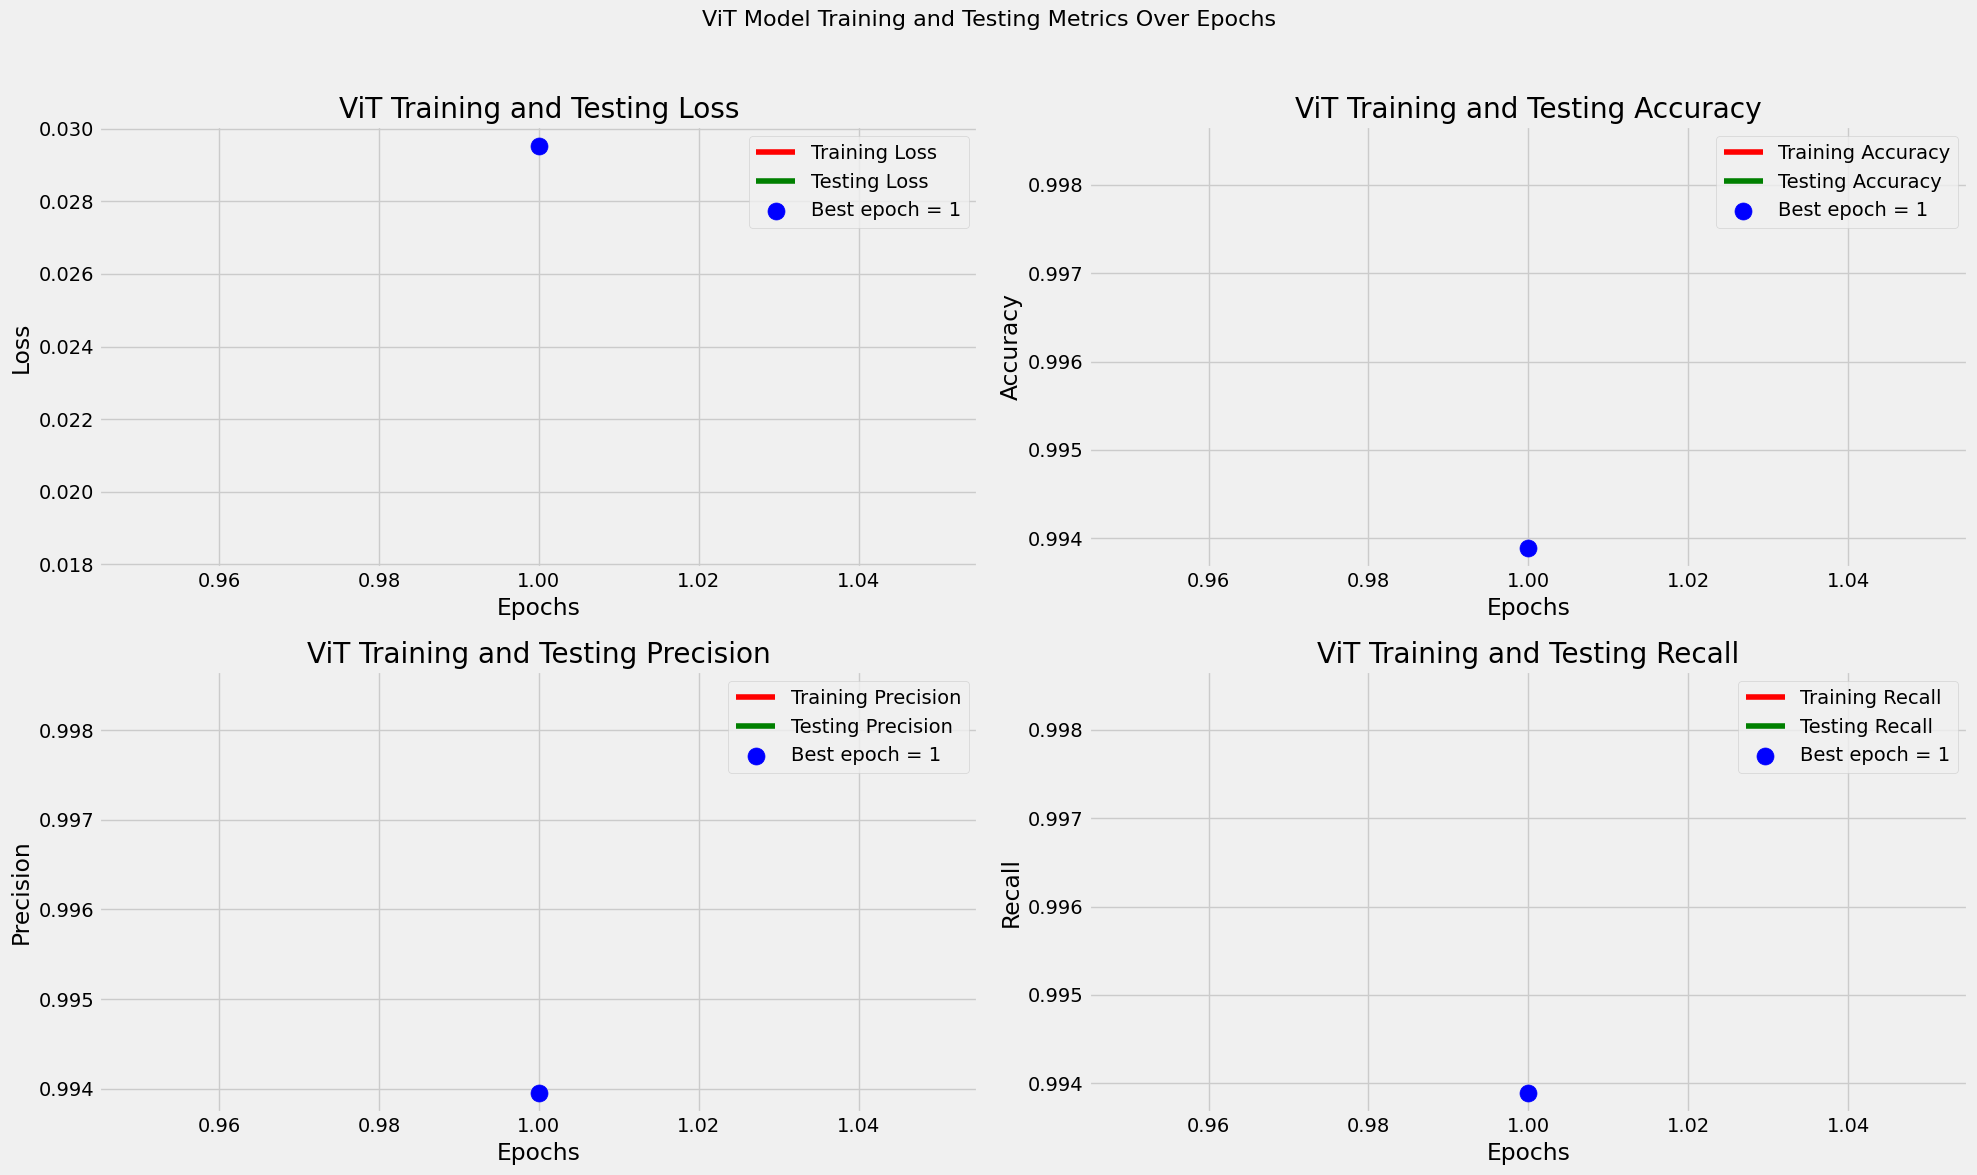

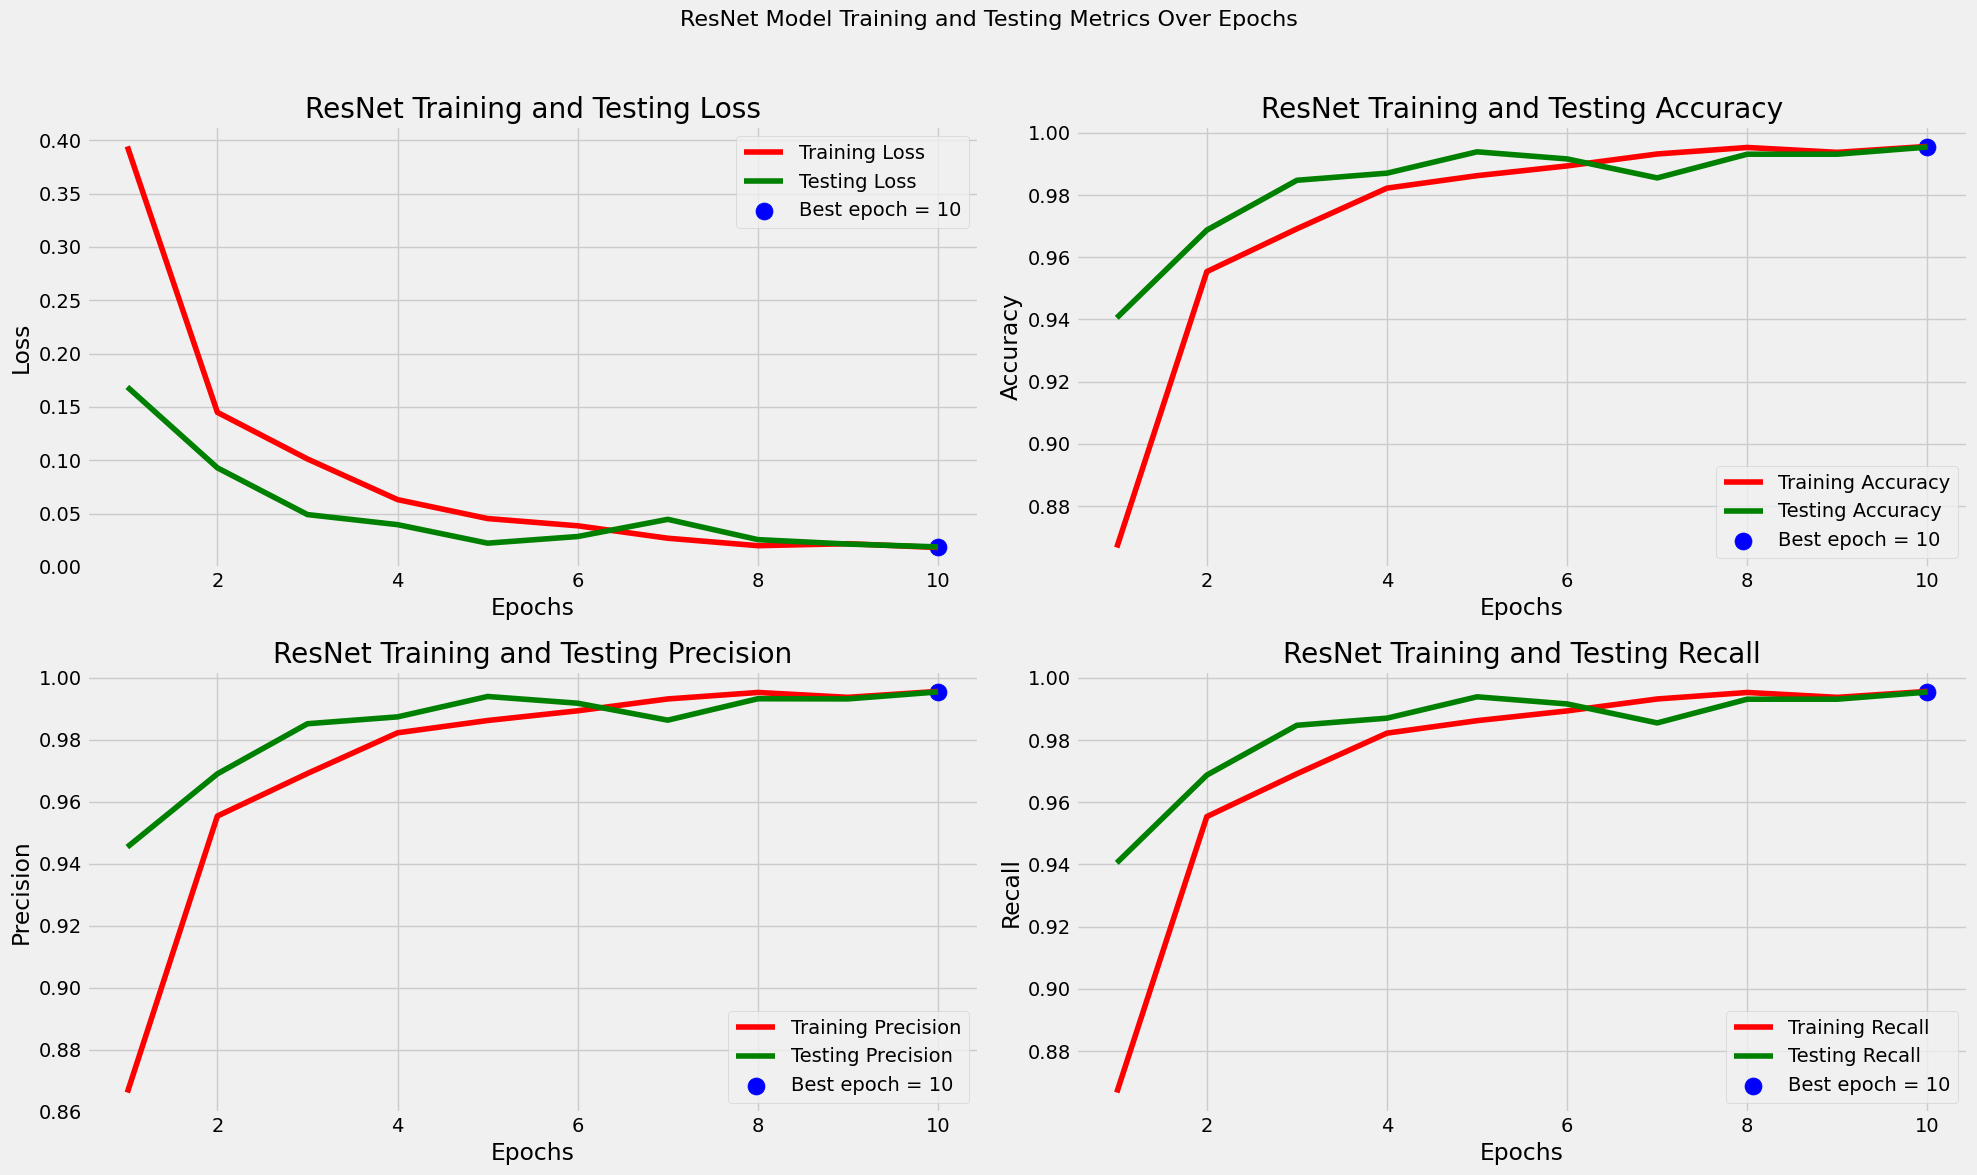

In [33]:
# Visualize hybrid predictions
def denormalize(img, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]):
    img = img.clone()
    for i in range(3):
        img[i] = img[i] * std[i] + mean[i]
    img = img.permute(1, 2, 0)
    img = img.clamp(0, 1)
    return img

classes = train_dataset.classes
images, labels = next(iter(test_loader))

with torch.no_grad():
    images_dev = images.to(device)
    outputs = hybrid_model(images_dev)
    _, preds = torch.max(outputs, dim=1)
    preds = preds.cpu().numpy()

plt.figure(figsize=(20, 20))
for i in range(min(16, len(images))):
    plt.subplot(4, 4, i + 1)
    img = denormalize(images[i]).numpy()
    plt.imshow(img)
    plt.title(classes[preds[i]], color='k', fontsize=15)
    plt.axis('off')
plt.tight_layout()
plt.savefig('/content/drive/MyDrive/hybrid_test_batch_visualization.png')  # Fixed path
plt.show()

# Plot metrics for both models (separate figures)
plt.style.use('fivethirtyeight')

# ViT Metrics
plt.figure(figsize=(20, 12))

# Use the actual length of your metrics arrays
actual_epochs = len(vit_train_losses)
epoch_range = range(1, actual_epochs + 1)

# Loss
if len(vit_test_losses) > 0:
    index_loss = np.argmin(vit_test_losses)
    plt.subplot(2, 2, 1)
    plt.plot(epoch_range, vit_train_losses, 'r', label='Training Loss')
    plt.plot(epoch_range, vit_test_losses, 'g', label='Testing Loss')
    plt.scatter(index_loss + 1, vit_test_losses[index_loss], s=150, c='blue', label=f'Best epoch = {index_loss+1}')
    plt.title('ViT Training and Testing Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

# Accuracy
if len(vit_test_accs) > 0:
    index_acc = np.argmax(vit_test_accs)
    plt.subplot(2, 2, 2)
    plt.plot(epoch_range, vit_train_accs, 'r', label='Training Accuracy')
    plt.plot(epoch_range, vit_test_accs, 'g', label='Testing Accuracy')
    plt.scatter(index_acc + 1, vit_test_accs[index_acc], s=150, c='blue', label=f'Best epoch = {index_acc+1}')
    plt.title('ViT Training and Testing Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)

# Precision
if len(vit_test_precisions) > 0:
    index_precision = np.argmax(vit_test_precisions)
    plt.subplot(2, 2, 3)
    plt.plot(epoch_range, vit_train_precisions, 'r', label='Training Precision')
    plt.plot(epoch_range, vit_test_precisions, 'g', label='Testing Precision')
    plt.scatter(index_precision + 1, vit_test_precisions[index_precision], s=150, c='blue', label=f'Best epoch = {index_precision+1}')
    plt.title('ViT Training and Testing Precision')
    plt.xlabel('Epochs')
    plt.ylabel('Precision')
    plt.legend()
    plt.grid(True)

# Recall
if len(vit_test_recalls) > 0:
    index_recall = np.argmax(vit_test_recalls)
    plt.subplot(2, 2, 4)
    plt.plot(epoch_range, vit_train_recalls, 'r', label='Training Recall')
    plt.plot(epoch_range, vit_test_recalls, 'g', label='Testing Recall')
    plt.scatter(index_recall + 1, vit_test_recalls[index_recall], s=150, c='blue', label=f'Best epoch = {index_recall+1}')
    plt.title('ViT Training and Testing Recall')
    plt.xlabel('Epochs')
    plt.ylabel('Recall')
    plt.legend()
    plt.grid(True)

plt.suptitle('ViT Model Training and Testing Metrics Over Epochs', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.savefig('/content/drive/MyDrive/vit_metrics_plot.png')  # Fixed path
plt.show()

# ResNet Metrics
plt.figure(figsize=(20, 12))

# Use the actual length of ResNet metrics arrays
actual_epochs_resnet = len(resnet_train_losses)
epoch_range_resnet = range(1, actual_epochs_resnet + 1)

# Loss
if len(resnet_test_losses) > 0:
    index_loss = np.argmin(resnet_test_losses)
    plt.subplot(2, 2, 1)
    plt.plot(epoch_range_resnet, resnet_train_losses, 'r', label='Training Loss')
    plt.plot(epoch_range_resnet, resnet_test_losses, 'g', label='Testing Loss')
    plt.scatter(index_loss + 1, resnet_test_losses[index_loss], s=150, c='blue', label=f'Best epoch = {index_loss+1}')
    plt.title('ResNet Training and Testing Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

# Accuracy
if len(resnet_test_accs) > 0:
    index_acc = np.argmax(resnet_test_accs)
    plt.subplot(2, 2, 2)
    plt.plot(epoch_range_resnet, resnet_train_accs, 'r', label='Training Accuracy')
    plt.plot(epoch_range_resnet, resnet_test_accs, 'g', label='Testing Accuracy')
    plt.scatter(index_acc + 1, resnet_test_accs[index_acc], s=150, c='blue', label=f'Best epoch = {index_acc+1}')
    plt.title('ResNet Training and Testing Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)

# Precision
if len(resnet_test_precisions) > 0:
    index_precision = np.argmax(resnet_test_precisions)
    plt.subplot(2, 2, 3)
    plt.plot(epoch_range_resnet, resnet_train_precisions, 'r', label='Training Precision')
    plt.plot(epoch_range_resnet, resnet_test_precisions, 'g', label='Testing Precision')
    plt.scatter(index_precision + 1, resnet_test_precisions[index_precision], s=150, c='blue', label=f'Best epoch = {index_precision+1}')
    plt.title('ResNet Training and Testing Precision')
    plt.xlabel('Epochs')
    plt.ylabel('Precision')
    plt.legend()
    plt.grid(True)

# Recall
if len(resnet_test_recalls) > 0:
    index_recall = np.argmax(resnet_test_recalls)
    plt.subplot(2, 2, 4)
    plt.plot(epoch_range_resnet, resnet_train_recalls, 'r', label='Training Recall')
    plt.plot(epoch_range_resnet, resnet_test_recalls, 'g', label='Testing Recall')
    plt.scatter(index_recall + 1, resnet_test_recalls[index_recall], s=150, c='blue', label=f'Best epoch = {index_recall+1}')
    plt.title('ResNet Training and Testing Recall')
    plt.xlabel('Epochs')
    plt.ylabel('Recall')
    plt.legend()
    plt.grid(True)

plt.suptitle('ResNet Model Training and Testing Metrics Over Epochs', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.savefig('/content/drive/MyDrive/resnet_metrics_plot.png')  # Fixed path
plt.show()